In [49]:
import pandas as pd
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import xgboost as xgb
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

'''Predefined Functions for EDA'''
def eda(data):
    print("----------Top-5- Record----------")
    print(data.head(5))
    print("-----------Information-----------")
    print(data.info())
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Missing value-----------")
    print(data.isnull().sum())
    print("----------Null value-----------")
    print(data.isna().sum())
    print("----------Shape of Data----------")
    print(data.shape)
def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)
def unresanable_data(data):
    print("Min Value:",data.min())
    print("Max Value:",data.max())
    print("Average Value:",data.mean())
    print("Center Point of Data:",data.median())


In [65]:
shops=pd.read_csv('data/predict_future_sales/shops.csv')
train=pd.read_csv('data/predict_future_sales/sales_train.csv')
items=pd.read_csv('data/predict_future_sales/items.csv')
item_category=pd.read_csv('data/predict_future_sales/item_categories.csv')
test=pd.read_csv('data/predict_future_sales/test.csv')
sample=pd.read_csv('data/predict_future_sales/sample_submission.csv')


### Drop dup 

In [66]:
# Drop Duplicate Data
subset = ['date', 'date_block_num', 'shop_id', 'item_id','item_cnt_day']
drop_duplicate(train, subset = subset)

Before drop shape: (2935849, 6)
After drop shape: (2935825, 6)
Total Duplicate: 24


## EDA

In [ ]:
eda(train)
graph_insight(train)

### Dig deep into the item price to check outliers

In [53]:
prices,occ=np.unique(train.item_price.values.tolist(),return_counts=True)


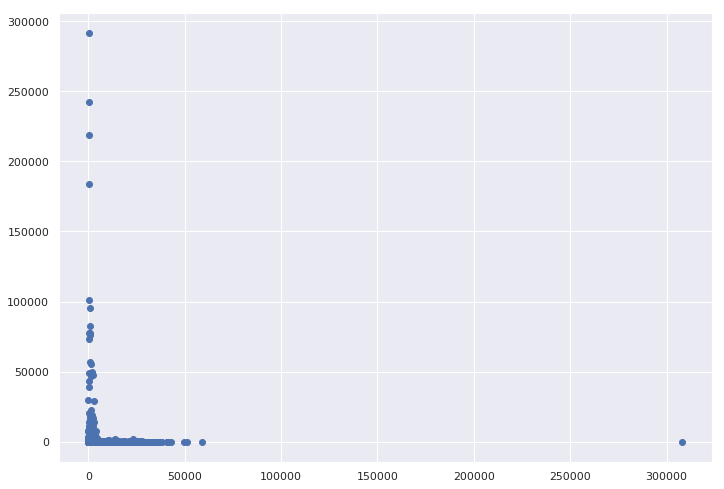

In [54]:
plt.scatter(x=prices,y=occ)

In [67]:
train = train[(train.item_price > 0) & (train.item_price < 300000)]


In [68]:
unresanable_data(train['item_price'])


Min Value: 0.07
Max Value: 59200.0
Average Value: 890.7514892291379
Center Point of Data: 399.0


### map the categories to metacategories

In [69]:
l = list(item_category.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


item_category['cats'] = l_cat
item_category.head()


,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [71]:
train['date']=pd.to_datetime(train.date,format='%d.%m.%Y')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [72]:
train=train.groupby([ 'shop_id','item_id','date_block_num'],as_index=False).agg({'item_cnt_day':sum,
                                                             'item_price': 'mean',      # find the sum of the durations for each group
                                     'date': 'first'})  # get the first date per group
train.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price,date
0,0,30,1,31.0,265.0,2013-02-21
1,0,31,1,11.0,434.0,2013-02-15
2,0,32,0,6.0,221.0,2013-01-03
3,0,32,1,10.0,221.0,2013-02-25
4,0,33,0,3.0,347.0,2013-01-03


In [36]:
'''## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()
'''

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [37]:
''''## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')
''''

In [38]:
'''item_to_cat_df = items.merge(item_category[['item_category_id','cats']], how="inner", on="item_category_id")[['item_id','cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')
'''


In [39]:
'''train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df.head()'''

,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,cats
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
1,1,30,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
3,3,30,0.0,4.0,5.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7
4,4,30,0.0,7.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


In [40]:
'''train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()'''


,shop_id,item_id,cats,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
'''param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)'''

"param = {'max_depth':10, \n         'subsample':1,\n         'min_child_weight':0.5,\n         'eta':0.3, \n         'num_round':1000, \n         'seed':1,\n         'silent':0,\n         'eval_metric':'rmse'}\n\nxgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)\nwatchlist  = [(xgbtrain,'train-rmse')]\n\nbst = xgb.train(param, xgbtrain)\npreds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))\nfrom sklearn.metrics import mean_squared_error \nrmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))\nprint(rmse)"

In [73]:
train['month']=train['date'].apply(lambda x : x.month)
train['item_cnt_day']=train['item_cnt_day'].apply(lambda x : x if x>0 else 0)
train['year']=train['date'].apply(lambda x : x.year)
test['year']=[2015 for a in range (test.shape[0])]## Static for the test 
test['month']=[11 for a in range (test.shape[0])]## Static for the test 

In [74]:
## joint to bring category id 
train=pd.merge(train, items, on='item_id',how='left',suffixes=('_left', '_right'))
train.head()



,shop_id,item_id,date_block_num,item_cnt_day,item_price,date,month,year,item_name,item_category_id
0,0,30,1,31.0,265.0,2013-02-21,2,2013,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
1,0,31,1,11.0,434.0,2013-02-15,2,2013,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37
2,0,32,0,6.0,221.0,2013-01-03,1,2013,1+1,40
3,0,32,1,10.0,221.0,2013-02-25,2,2013,1+1,40
4,0,33,0,3.0,347.0,2013-01-03,1,2013,1+1 (BD),37


 we have 5 item/shop combo that does not exist in the train 

In [75]:
test.head()

,ID,shop_id,item_id,year,month
0,0,5,5037,2015,11
1,1,5,5320,2015,11
2,2,5,5233,2015,11
3,3,5,5232,2015,11
4,4,5,5268,2015,11


In [76]:
num_month = 34
month_list=[i for i in range(num_month+1)]
shop = []
for i in range(num_month+1):
    shop.append(1)
item = []
for i in range(num_month+1):
    item.append(1)
months_full = pd.DataFrame.from_dict({'shop_id':shop, 'item_id':item,'date_block_num':month_list})
gbm = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
#gbm.fit(data.drop('Survived',axis=1).values, data['Survived'].values)

#res=xgb_random.predict(to_predict.drop(columns=['Survived']).values)

In [ ]:
check = train
gbm.fit(check[['shop_id','item_id','month','year']].values, check['item_cnt_day'].values)


In [81]:
gbm.predict([1,1,1,1])

array([3.0201662], dtype=float32)

In [83]:
def getXGBoost_predict(row):
    #print(row[['shop_id','item_id','month']].values)
    res=gbm.predict(row[['shop_id','item_id','month','year']].values.tolist())
    #print(res)
    return res[0]

In [86]:
%%time
f = open('predictions.txt','a')
submit=pd.DataFrame.from_dict({'ID':test['ID'],'item_cnt_month':test['ID']})
for x in range(test.shape[0]):
    #print(test.iloc[x])
    prediction=getXGBoost_predict(test.iloc[x])
    if x%100000==0:
        print(prediction)
        print(test.iloc[x].values)
    submit.loc[x,'item_cnt_month']=prediction
    f.write(str(prediction)+'\n')
    
f.close()

1.6814798
[   0    5 5037 2015   11]
1.7933248
[100000     19   4364   2015     11]
2.296212
[200000     44  10211   2015     11]
CPU times: user 8min 7s, sys: 1.98 s, total: 8min 9s
Wall time: 8min 9s


In [93]:
submit.drop(columns=['prediction'],inplace=True)

In [94]:
submit.head()

,ID,item_cnt_month
0,0,1.681480
1,1,1.969676
2,2,2.134542
3,3,2.098997
4,4,1.691869


In [95]:
submit.to_csv('Submission_Predict Sales_xgb_regressor.csv',index=False)

-----------END--------------------------------------

#### Checking if the item count day are all positive ?? 

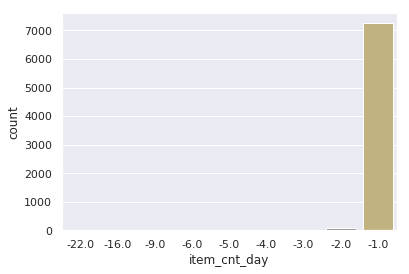

In [10]:
ax = sns.countplot(x="item_cnt_day", data=train[train['item_cnt_day']<0])

#### adding month to data frame 

In [11]:
train=train.groupby([ 'date_block_num','shop_id','item_id'],sort=True,as_index=False).agg({'item_cnt_day':sum,
                                                             'item_price': 'mean', 
                                                            'date': 'first'}) 

In [12]:
train['month']=train['date'].apply(lambda x : x.month)
train['year']=train['date'].apply(lambda x : x.year)
test['year']=[2015 for a in range (test.shape[0])]## Static for the test 
test['month']=[11 for a in range (test.shape[0])]## Static for the test 

In [13]:
test.head()

,ID,shop_id,item_id,year,month
0,0,5,5037,2015,11
1,1,5,5320,2015,11
2,2,5,5233,2015,11
3,3,5,5232,2015,11
4,4,5,5268,2015,11


In [14]:
train.shop_id.unique()

array([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 12, 13, 14, 15, 16, 18, 19, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 41, 42, 43,
       44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 59,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36])

In [15]:
## joint to bring category id 
train=pd.merge(train, items, on='item_id',how='left',suffixes=('_left', '_right'))
train.head()



,date_block_num,shop_id,item_id,item_cnt_day,item_price,date,month,year,item_name,item_category_id
0,0,0,32,6.0,221.0,2013-01-03,1,2013,1+1,40
1,0,0,33,3.0,347.0,2013-01-03,1,2013,1+1 (BD),37
2,0,0,35,1.0,247.0,2013-01-31,1,2013,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1.0,221.0,2013-01-31,1,2013,100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,2.0,128.5,2013-01-13,1,2013,100 лучших произведений классики (mp3-CD) (Dig...,57


In [16]:
## joint to bring category id to test
test=pd.merge(test, items, on='item_id',how='left',suffixes=('_left', '_right'))
test.head()


,ID,shop_id,item_id,year,month,item_name,item_category_id
0,0,5,5037,2015,11,"NHL 15 [PS3, русские субтитры]",19
1,1,5,5320,2015,11,ONE DIRECTION Made In The A.M.,55
2,2,5,5233,2015,11,"Need for Speed Rivals (Essentials) [PS3, русск...",19
3,3,5,5232,2015,11,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23
4,4,5,5268,2015,11,"Need for Speed [PS4, русская версия]",20


In [17]:
#super fucking awesome
pivot_df = train.pivot_table(index=['shop_id','item_category_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
pivot_df.head()


date_block_num              0     1    2    3    4    5    6    7    8    9   \
shop_id item_category_id                                                       
0       0                  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        1                  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        2                 53.0  52.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        3                 28.0  24.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        4                 16.0  22.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date_block_num           ...    24   25   26   27   28   29   30   31   32  \
shop_id item_category_id ...                                                 
0       0                ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        1                ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        2                ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        3                ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        4                ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

date_block_num             33  
shop_id item_category_id       
0       0                 0.0  
        1                 0.0  
        2                 0.0  
        3                 0.0  
        4                 0.0  

[5 rows x 34 columns]

In [18]:
pivot_df = pd.DataFrame(pivot_df.to_records())
pivot_df.head()

,shop_id,item_category_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,53.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,28.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,4,16.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
pivot_df.shop_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [20]:
pivot_df.item_category_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6, 11, 13, 14, 15, 19, 21, 22, 23, 25, 28,
       29, 30, 33, 35, 37, 38, 40, 41, 43, 45, 49, 55, 56, 57, 59, 60, 62,
       63, 64, 65, 67, 69, 70, 71, 72, 73, 75, 77, 81, 82, 83, 58,  7,  8,
       12, 16, 17, 20, 24, 32, 39, 42, 47, 61, 79, 80, 52, 46, 53, 66, 50,
        9, 48, 68, 18, 10, 51, 26, 27, 31, 34, 36, 44, 54, 74, 76, 78])

####  Too much to plot, group them by category and see the trend 

In [21]:
#super fucking awesome
pivot_category_df = train.pivot_table(index=['item_category_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
pivot_category_df = pd.DataFrame(pivot_category_df.to_records())
pivot_category_df.head()

,item_category_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,...,370.0,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0,82.0
3,3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,...,1398.0,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0,1059.0
4,4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,...,10.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0


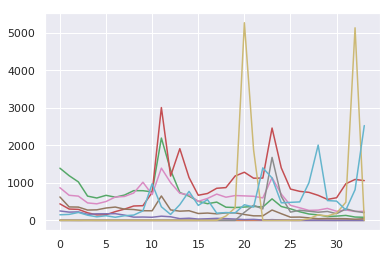

In [22]:
months=[a for a in range(34)]
for cat in pivot_category_df.item_category_id.unique()[:10]:
    sns.lineplot(x=months,y=pivot_category_df[pivot_category_df['item_category_id']==cat].drop(columns=['item_category_id']).values[0])


In [23]:
pivot_category_df.item_category_id.unique().shape

(84,)

In [24]:
sells_per_cat=train.groupby(['date_block_num','shop_id','item_category_id'],as_index = False)['item_cnt_day'].sum()
sells_per_cat.columns=['date_block_num','shop_id','item_category_id','item_cnt_category']
sells_per_cat.head()


,date_block_num,shop_id,item_category_id,item_cnt_category
0,0,0,2,53.0
1,0,0,3,28.0
2,0,0,4,16.0
3,0,0,5,28.0
4,0,0,6,65.0


####  plot all items sells of every item by month for all shops

In [25]:
train.shape

(1609124, 10)

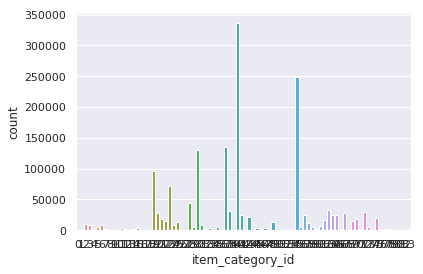

In [26]:
g = sns.countplot(x="item_category_id", data=train)


In [27]:
all_items_sells=train[['date_block_num','item_cnt_day','item_category_id']]
all_items_sells=all_items_sells.groupby(['date_block_num','item_category_id'],as_index=False).sum()
all_items_sells.head()

,date_block_num,item_category_id,item_cnt_day
0,0,0,1.0
1,0,1,1.0
2,0,2,1390.0
3,0,3,440.0
4,0,4,251.0


#### See the trend on prices level 

In [28]:
all_items_prices=train[['date_block_num','item_price','item_id']]
all_items_prices=all_items_prices.groupby(['date_block_num','item_id'],as_index=False).mean()
all_items_prices.head()

,date_block_num,item_id,item_price
0,0,19,28.000000
1,0,27,2325.000000
2,0,28,549.000000
3,0,29,2346.750000
4,0,32,335.042318


In [29]:
all_items_sells=train[['date_block_num','item_cnt_day','item_category_id']]
all_items_sells=all_items_sells.groupby(['date_block_num','item_category_id'],as_index=False).sum()
all_items_sells.head()

,date_block_num,item_category_id,item_cnt_day
0,0,0,1.0
1,0,1,1.0
2,0,2,1390.0
3,0,3,440.0
4,0,4,251.0


In [30]:
train.tail(2)

,date_block_num,shop_id,item_id,item_cnt_day,item_price,date,month,year,item_name,item_category_id
1609122,33,59,22100,1.0,629.0,2015-10-18,10,2015,Энциклопедия Adventure Time,42
1609123,33,59,22102,1.0,1250.0,2015-10-16,10,2015,Энциклопедия Мир Ведьмака,42


#### Try LSTM on one shop/item comb form test 

In [36]:
def getLSTM_predict(shop_id,item_id):
    ## extract the item/shop history  froom training
    check = history_df.loc[history_df['shop_id'] == shop_id]
    check = history_df.loc[history_df['item_id'] == item_id]
    # prepare empty df for the full history of the item in case it was not sold on 
    # a specific month or something
    num_month = 34
    month_list=[i for i in range(num_month+1)]
    shop = []
    for i in range(num_month+1):
        shop.append(shop_id)
    item = []
    for i in range(num_month+1):
        item.append(item_id)
    
    months_full = pd.DataFrame.from_dict({'shop_id':shop, 'item_id':item,'date_block_num':month_list})
    # merge it with the history df to add  the missing months to the history
    sales_33month = pd.merge(check, months_full, how='right', on=['shop_id','item_id','date_block_num'])
    sales_33month = sales_33month.sort_values(by=['date_block_num'])
    sales_33month.fillna(0.00,inplace=True)
    for i in range(1,6):
        sales_33month["T_" + str(i)] = sales_33month.item_cnt_day.shift(i)
    sales_33month.fillna(0.0, inplace=True)
    df = sales_33month[['shop_id','item_id','date_block_num','T_1','T_2','T_3','T_4','T_5', 'item_cnt_day']].reset_index()
    df = df.drop(labels = ['index'], axis = 1)
    train_df = df[:-1]
    val_df = df[-1:]
    x_train,y_train = train_df.drop(["item_cnt_day"],axis=1),train_df.item_cnt_day
    x_val,y_val = val_df.drop(["item_cnt_day"],axis=1),val_df.item_cnt_day
    # define lstm model 
    model_lstm = Sequential()
    model_lstm.add(LSTM(15, input_shape=(1,8)))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    # Reshape the data between -1 and 1 and to 3D
    scaler = StandardScaler()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train_scaled = scaler.fit_transform(x_train)
    x_valid_scaled = scaler.fit_transform(x_val)
    ## reshape to prepare array of ent
    x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
    x_val_resaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))
    history = model_lstm.fit(x_train_reshaped, y_train,epochs=70, batch_size=12, verbose=0, shuffle=False)
    y_pre = model_lstm.predict(x_val_resaped)
    return y_pre



In [37]:
history_df = train[["shop_id","item_id","date_block_num","item_cnt_day"]]

In [ ]:
%%time
predictions=[]
for x in range(test.shape[0]):
    predictions.append(getLSTM_predict(test['shop_id'][x],test['item_id'][x]))
    print('done')

###### detailed version

In [58]:
check = train[["shop_id","item_id","date_block_num","item_cnt_day"]]
check = check.loc[check['shop_id'] == 5]
check = check.loc[check['item_id'] == 5037]
check

,shop_id,item_id,date_block_num,item_cnt_day
1068808,5,5037,20,1.0
1152033,5,5037,22,1.0
1198523,5,5037,23,2.0
1257193,5,5037,24,2.0
1418300,5,5037,28,1.0
1450581,5,5037,29,1.0
1482457,5,5037,30,1.0
1516128,5,5037,31,3.0
1549379,5,5037,32,1.0


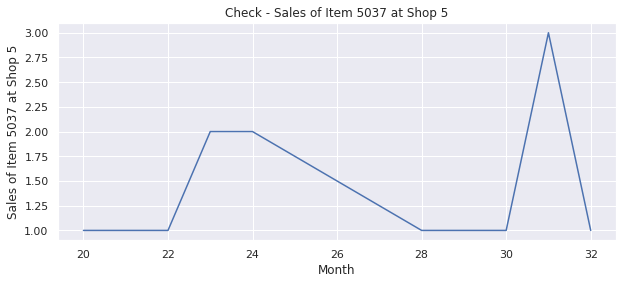

In [59]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Item 5037 at Shop 5')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 5')
plt.plot(check["date_block_num"],check["item_cnt_day"]);


In [63]:
num_month = train['date_block_num'].max()
month_list=[i for i in range(num_month+1)]
shop = []
for i in range(num_month+1):
    shop.append(5)
item = []
for i in range(num_month+1):
    item.append(5037)
months_full = pd.DataFrame({'shop_id':shop, 'item_id':item,'date_block_num':month_list})


In [81]:
sales_33month = pd.merge(check, months_full, how='right', on=['shop_id','item_id','date_block_num'])
sales_33month = sales_33month.sort_values(by=['date_block_num'])
sales_33month.fillna(0.00,inplace=True)
sales_33month

,shop_id,item_id,date_block_num,item_cnt_day
9,5,5037,0,0.0
10,5,5037,1,0.0
11,5,5037,2,0.0
12,5,5037,3,0.0
13,5,5037,4,0.0
14,5,5037,5,0.0
15,5,5037,6,0.0
16,5,5037,7,0.0
17,5,5037,8,0.0
18,5,5037,9,0.0


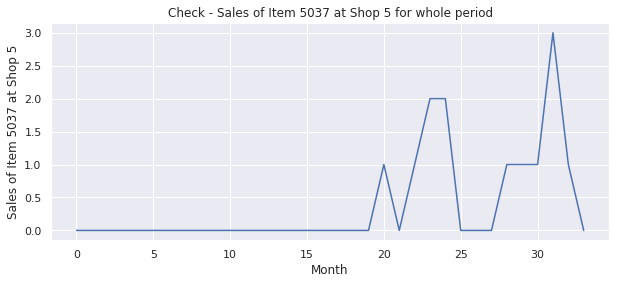

In [82]:
plt.figure(figsize=(10,4))
plt.title('Check - Sales of Item 5037 at Shop 5 for whole period')
plt.xlabel('Month')
plt.ylabel('Sales of Item 5037 at Shop 5')
plt.plot(sales_33month["date_block_num"],sales_33month["item_cnt_day"]);

In [83]:
for i in range(1,6):
    sales_33month["T_" + str(i)] = sales_33month.item_cnt_day.shift(i)
sales_33month.fillna(0.0, inplace=True)
sales_33month.head()

,shop_id,item_id,date_block_num,item_cnt_day,T_1,T_2,T_3,T_4,T_5
9,5,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
10,5,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
11,5,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
12,5,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
13,5,5037,4,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
df = sales_33month[['shop_id','item_id','date_block_num','T_1','T_2','T_3','T_4','T_5', 'item_cnt_day']].reset_index()
df = df.drop(labels = ['index'], axis = 1)
df

,shop_id,item_id,date_block_num,T_1,T_2,T_3,T_4,T_5,item_cnt_day
0,5,5037,0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,5037,1,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5037,2,0.0,0.0,0.0,0.0,0.0,0.0
3,5,5037,3,0.0,0.0,0.0,0.0,0.0,0.0
4,5,5037,4,0.0,0.0,0.0,0.0,0.0,0.0
5,5,5037,5,0.0,0.0,0.0,0.0,0.0,0.0
6,5,5037,6,0.0,0.0,0.0,0.0,0.0,0.0
7,5,5037,7,0.0,0.0,0.0,0.0,0.0,0.0
8,5,5037,8,0.0,0.0,0.0,0.0,0.0,0.0
9,5,5037,9,0.0,0.0,0.0,0.0,0.0,0.0


#### Split data to train and validation

In [106]:
train_df = df[:-3]
val_df = df[-3:]
x_train,y_train = train_df.drop(["item_cnt_day"],axis=1),train_df.item_cnt_day
x_val,y_val = val_df.drop(["item_cnt_day"],axis=1),val_df.item_cnt_day

In [107]:
x_train.head()

,shop_id,item_id,date_block_num,T_1,T_2,T_3,T_4,T_5
0,5,5037,0,0.0,0.0,0.0,0.0,0.0
1,5,5037,1,0.0,0.0,0.0,0.0,0.0
2,5,5037,2,0.0,0.0,0.0,0.0,0.0
3,5,5037,3,0.0,0.0,0.0,0.0,0.0
4,5,5037,4,0.0,0.0,0.0,0.0,0.0


In [121]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape=(1,8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

In [122]:
# Reshape the data between -1 and 1 and to 3D
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_val)


/home/ubuntu/anaconda3/envs/hamza/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/envs/hamza/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [123]:
## reshape to prepare array of ent
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_resaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))


In [124]:
x_train_scaled.shape

(31, 8)

In [125]:
x_train_reshaped.shape

(31, 1, 8)

In [126]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_resaped, y_val),epochs=70, batch_size=12, verbose=0, shuffle=False)
y_pre = model_lstm.predict(x_val_resaped)


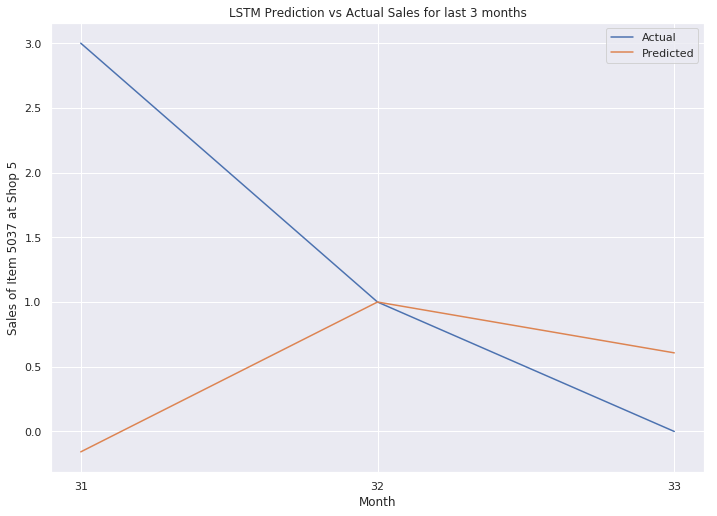

In [127]:
fig, ax = plt.subplots()
ax.plot(x_val['date_block_num'], y_val, label='Actual')
ax.plot(x_val['date_block_num'], y_pre, label='Predicted')
plt.title('LSTM Prediction vs Actual Sales for last 3 months')
plt.xlabel('Month')
plt.xticks(x_val['date_block_num'])
plt.ylabel('Sales of Item 5037 at Shop 5')
ax.legend()
plt.show()

In [128]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_val,y_pre))
print('Val RMSE: %.3f' % rmse)


Val RMSE: 1.857


#### Step 1 : Item price imputation 


##### Forcasting last value from same price same shop

#### Very slow ! get the last median price of the categories in a dict better 

In [36]:
category_median= train[['item_category_id','item_price']].groupby(['item_category_id'],as_index=False).median()
category_median.head()

,item_category_id,item_price
0,0,93.0
1,1,215.5
2,2,2390.0
3,3,1690.0
4,4,299.0


In [37]:
last_item_price_same_shop= train[['shop_id','item_id','item_price']].groupby(['shop_id','item_id'],as_index=False).last()
last_item_price_same_shop.head()
#last_item_price_same_shop[(last_item_price_same_shop['shop_id']==0 )& (last_item_price_same_shop['item_id']==33 )]

,shop_id,item_id,item_price
0,0,30,265.0
1,0,31,434.0
2,0,32,221.0
3,0,33,347.0
4,0,35,247.0


In [38]:
last_item_price_all_shop= train[['item_id','item_price']].groupby(['item_id'],as_index=False).last()
last_item_price_all_shop.head()


,item_id,item_price
0,0,58.0
1,1,4490.0
2,2,58.0
3,3,58.0
4,4,58.0


In [41]:
## redo this 
def get_last_price_same_shop(row):
    save a copy before then check size 
    if last_item_price_same_shop[(last_item_price_same_shop['item_id']==row['item_id'])&(last_item_price_same_shop['shop_id']==row['shop_id'])].empty:
        return last_item_price_same_shop[(last_item_price_same_shop['item_id']==row['item_id'])&(last_item_price_same_shop['shop_id']==row['shop_id'])]['item_price']
    if last_item_price_all_shop[(last_item_price_all_shop['item_id']==row['item_id'])].shape[0]>0:
        return last_item_price_same_shop[(last_item_price_same_shop['item_id']==row['item_id'])]['item_price']
    if category_median[category_median['item_category_id']==row['item_category_id']].shape[0]>0:
        return category_median[category_median['item_category_id']==row['item_category_id']]['item_price']
    print('not found ')
    return 1
validation['item_price']=validation.apply(lambda x : get_last_price_same_shop(x),axis=1)
validation.head()

SyntaxError: invalid syntax (<ipython-input-41-f83817f7cb44>, line 4)

#### Step 2 : item count prediction 